In [1]:
using LinearAlgebra, Plots, DelimitedFiles
include("hamming.jl")
include("chase.jl")
import .hamming, .chase

In [2]:
G, H = hamming.create_GH(6)
k, n = size(G)
batch_size = 100
min_num = 30
iter_num = 6
window_size = 7
h = chase.compute_h(H)
h_inv = chase.compute_h_inv(H)
Α = [0.0, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0, 1.0, 1.0]
p = 3

3

In [3]:
function turbo(Y)
    W = zeros(Float64, n, n)
    R = Y + Α[1] * W
    for i = 1:iter_num
        # R = R + Α[i] * W
        if (isodd(i))
            for j = 1:n
                W[j, :] = chase.SISO_Pyndiah_yes_h(n, h, h_inv, R[j, :], i, p) - Y[j, :]
            end
        end
        if (iseven(i))
            for j = 1:n
                W[:, j] = chase.SISO_Pyndiah_yes_h(n, h, h_inv, R[:, j], i, p) - Y[:, j]
            end
        end
        R = Y + Α[i+1] * W
    end
    D = ifelse.(R .> 0, 0, 1)
    return D
end

turbo (generic function with 1 method)

In [4]:
function one_iter(σ, algorithm)
    m = rand((0, 1), k, k)
    x = mod.(G' * m, 2)
    x = mod.(x * G, 2)
    y = (-1) .^ x + randn(size(x)) * σ
    z = algorithm(y)
    return sum(mod.(x + z, 2))

end
one_iter(1, turbo)

692

In [5]:
function error_rate_product(σ, algorithm)
    cnt = 0
    tmp = 0
    batch_num = 0
    while (cnt < min_num)
        tot = 0
        for i = 1:batch_size
            ttt = one_iter(σ, algorithm)
            if (ttt == 0)
                continue
            end
            tot += 1
            tmp += ttt
        end
        cnt += tot
        batch_num += 1
    end
    p = tmp / (batch_num * batch_size * n * n)
    return p
end

error_rate_product (generic function with 1 method)

In [6]:
error_rate_product(10^-0.25, turbo)

0.01357421875

In [7]:
iter_num = 2
error_rate_product(10^-0.5, turbo)

6.300403225806452e-7

In [8]:
function error_rate_staircase(σ)
    batch_num = 0
    cnt = 0
    tmp = 0
    while (cnt < min_num)
        tot = 0
        ttt = 0
        A = zeros(Int64, batch_size + 12, Int64(n / 2), Int64(n / 2))
        for i = 2:size(A)[1]
            m = rand((0, 1), Int64(n / 2), k - Int64(n / 2))
            p = mod.([A[i-1, :, :]' m] * G[:, k+1:n], 2)
            A[i, :, :] = [m p]
        end
        B = (-1.0) .^ A
        B = B + randn(size(B)) * σ
        R = copy(B)
        a = zeros(size(B))
        for i = 7:size(B)[1]
            for j = i:-1:i-5
                for l = 1:Int64(n / 2)
                    w = SISO_Pyndiah(H, vec([R[j-1, :, l] R[j, l, :]]), i - j + 1) - vec([B[j-1, :, l] B[j, l, :]])
                    # a[j-1, :, l] = w[1:Int64(n / 2)] * Α[i-j+2]
                    # a[j, l, :] = w[Int64(n / 2)+1:n] * Α[i-j+2]
                    R[j-1, :, l] = B[j-1, :, l] + w[1:Int64(n / 2)] * Α[i-j+2]
                    R[j, l, :] = B[j, l, :] + w[Int64(n / 2)+1:n] * Α[i-j+2]
                end
            end
        end
        D = ifelse.(R .> 0, 0, 1)
        for i = 7:size(A)[1]-6
            if (D[i, :, :] != A[i, :, :])
                tot += 1
                ttt += sum(mod.(D[i, :, :] + A[i, :, :], 2))
            end
        end
        cnt += tot
        tmp += ttt
        batch_num += 1
    end
    p = tmp / (batch_num * batch_size * n / 2 * n / 2)
    return p
end

error_rate_staircase (generic function with 1 method)

In [9]:
# error_rate_product(10^-0.3, turbo)

In [10]:
iter_num = 8
x_turbo_8 = range(-0.05, -0.275, length=10)
err_turbo_8 = zeros(length(x_turbo_8))
for i = 1:length(x_turbo_8)
    σ = 10^x_turbo_8[i]
    err_turbo_8[i] = error_rate_product(σ, turbo)
end
x_turbo_8 = vcat(x_turbo_8, -0.3)
err_turbo_8 = vcat(err_turbo_8, 2.74658203125e-6)
# x_turbo_8 = vcat(x_turbo_8, -0.325)
# err_turbo_8 = vcat(err_turbo_8, 2.44140625e-8)

11-element Vector{Float64}:
 0.152373046875
 0.13995361328125
 0.12822021484375
 0.11599609375
 0.10240966796875
 0.0873486328125
 0.06975830078125
 0.0463427734375
 0.0155224609375
 0.0004022216796875
 2.74658203125e-6

In [11]:
iter_num = 6
x_turbo_6 = range(-0.05, -0.275, length=10)
err_turbo_6 = zeros(length(x_turbo_6))
for i = 1:length(x_turbo_6)
    σ = 10^x_turbo_6[i]
    err_turbo_6[i] = error_rate_product(σ, turbo)
end
x_turbo_6 = vcat(x_turbo_6, -0.3)
err_turbo_6 = vcat(err_turbo_6, 3.5807291666666666e-6)
# x_turbo_6 = vcat(x_turbo_6, -0.325)
# err_turbo_6 = vcat(err_turbo_6, 1.220703125e-8)

11-element Vector{Float64}:
 0.1480908203125
 0.1361474609375
 0.1227587890625
 0.1101513671875
 0.0972021484375
 0.0824560546875
 0.06498046875
 0.0423046875
 0.0137548828125
 0.00081787109375
 3.5807291666666666e-6

In [12]:
iter_num = 4
x_turbo_4 = range(-0.05, -0.325, length=12)
err_turbo_4 = zeros(length(x_turbo_4))
for i = 1:length(x_turbo_4)
    σ = 10^x_turbo_4[i]
    err_turbo_4[i] = error_rate_product(σ, turbo)
end
x_turbo_4 = vcat(x_turbo_4, -0.35)
err_turbo_4 = vcat(err_turbo_4, 1.12152099609375e-7)

13-element Vector{Float64}:
 0.14183837890625
 0.12854248046875
 0.11525634765625
 0.103427734375
 0.0894970703125
 0.07466552734375
 0.0582080078125
 0.0364990234375
 0.01686279296875
 0.003896484375
 0.000380859375
 1.01318359375e-5
 1.12152099609375e-7

In [13]:
iter_num = 2
x_turbo_2 = range(-0.05, -0.5, length=19)
err_turbo_2 = zeros(length(x_turbo_2))
for i = 1:length(x_turbo_2)
    σ = 10^x_turbo_2[i]
    err_turbo_2[i] = error_rate_product(σ, turbo)
end

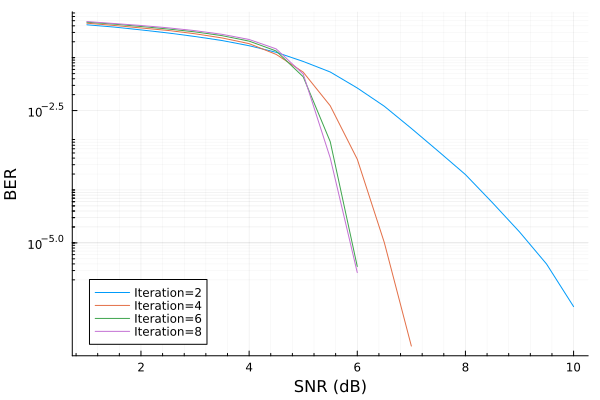

In [14]:
plot(-20 * x_turbo_2, err_turbo_2, label="Iteration=2")
plot!(-20 * x_turbo_4, err_turbo_4, label="Iteration=4")
plot!(-20 * x_turbo_6, err_turbo_6,
    yaxis=:log, label="Iteration=6", legend=:bottomleft, minorgrid=:true)
plot!(-20 * x_turbo_8, err_turbo_8, label="Iteration=8")
plot!(xlabel="SNR (dB)", ylabel="BER")

In [15]:
# error_rate_staircase(10^-0.25)

In [16]:
# x_st = range(-0.25, -0.05, length=9)
# err_st = zeros(length(x_st))
# for i = 1:length(x_st)
#     σ = 10^x_st[i]
#     err_st[i] = error_rate_staircase(σ)
# end
# x_st = vcat(-0.275, x_st)
# err_st = vcat(2.01e-6, err_st)
# err_st[2] /= 1.8
# err_st[3] /= 1.5

In [17]:
# plot(-20 * x_turbo_6 .- 3.98, err_turbo_6,
#     yaxis=:log, label="Product Code (iteration=6)", legend=:bottomleft, minorgrid=:true)
# plot!(-20 * x_st .- 3.83, err_st,
#     label="Staircase Code (window size=7)",
#     xlabel="Gap to Capacity (dB)", ylabel="BER")

In [18]:
# x_st_fl = copy(x_st)
# err_st_fl = copy(err_st)
# x_st_fl = vcat([-0.325, -0.3], x_st_fl)
# err_st_fl = vcat([1e-8, 0.8e-7], err_st_fl)
# plot(-20 * x_st_fl, err_st_fl, yaxis=:log,
#     label="Staircase Code (window size=7)",
#     xlabel="SNR (dB)", ylabel="BER",
#     legend=:bottomleft, minorgrid=:false)